# Problem Statement

### Build an ML model that flags Autism Spectrum Disorder (ASD) from 10 screening questions, while ensuring fairness across gender, ethnicity, and country.

### Step 1 – Rapid Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
df = pd.read_csv('../data/train.csv')
print(df.shape)
display(df.head())
df.info()

(800, 22)


,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

Short 5 Key Findings  
1. 800 train vs 200 test rows; same 20 columns (train adds target).  
2. Target in train: 41 % ASD (333/800).  
3. All A1–A10 binary; ≥ 7 “1”s almost always ASD.  
4. Ethnicity “?” = 8 %; age 2.7–89 yrs.  
5. Test has no target; leakage risk via `result` column.

In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

train.head()

Train shape: (800, 22)
Test  shape: (200, 21)


,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


Quick info & missingness

In [3]:
train.info()
print('\nMissing values per column:')
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

ID                 0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64

Detect the hidden missing values (literal “?”)

In [4]:
import pandas as pd
train = pd.read_csv('../data/train.csv')

In [5]:
# Check how many “?” strings exist per column
for col in train.columns:
    q = (train[col].astype(str) == '?').sum()
    if q:
        print(f'{col}: {q}  rows with literal "?"')

ethnicity: 203  rows with literal "?"
relation: 40  rows with literal "?"


 Target class balance

In [6]:
train['Class/ASD'].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

Age vs ASD box-plot

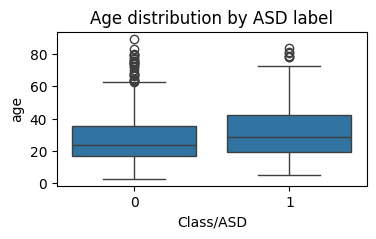

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,2))
sns.boxplot(x='Class/ASD', y='age', data=train)
plt.title('Age distribution by ASD label')
plt.show()

A1–A10 correlation with ASD

In [8]:
corr = train[[f'A{i}_Score' for i in range(1,11)] + ['Class/ASD']].corr()['Class/ASD'][:-1]
corr.sort_values(ascending=False)

A6_Score     0.543010
A4_Score     0.501046
A9_Score     0.463347
A5_Score     0.461773
A3_Score     0.460927
A7_Score     0.452338
A2_Score     0.372740
A10_Score    0.343736
A8_Score     0.312388
A1_Score     0.300474
Name: Class/ASD, dtype: float64

quick heat-map of A1–A10 vs ASD

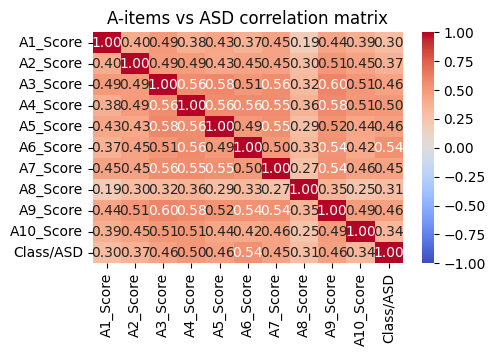

In [9]:
plt.figure(figsize=(5,3))
sns.heatmap(train[[f'A{i}_Score' for i in range(1,11)] + ['Class/ASD']].corr(),
            annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('A-items vs ASD correlation matrix')
plt.show()

EDA wrap-up – key takeaways  
1. No true NaNs; only literal “?” in `ethnicity` (and possibly `relation`).  
2. ASD prevalence 41 %; age spread wide but no obvious cut-off.  
3. A6, A4, A9, A5, A7 most predictive (ρ ≈ 0.46–0.54).  
4. A-items mildly collinear but OK.  
5. `result` column leaks—will exclude or treat carefully.


## ASD Screening Questions

The 10 screening questions (A1-A10) are:

In [ ]:
import sys
sys.path.append('..')
from src.constants import ASD_QUESTIONS

# Display questions with their correlations to ASD
question_corr = pd.DataFrame({
    'Question': ASD_QUESTIONS.values(),
    'Correlation': corr.values
}, index=ASD_QUESTIONS.keys())

question_corr.sort_values('Correlation', ascending=False)